In [1]:
import torch.nn as nn
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataloader.svdd_dataloader import CollisionLoader_audio as CollisionLoader_new
from nets.gaussianNet import GaussianSVDDModel 
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

train_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_test'
train_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_test'
test_audio = '/home/iot/collision_detect/new_data/audio_np/Abnormal'
test_imu = '/home/iot/collision_detect/new_data/imu_np/Abnormal'
real_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_train'
real_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_train'
workers = 4
feature_dim = 32
batchsize = 64
use_attention = 1

checkpoint_path = f'/home/iot/GSVDD/output/test/model_32_29_final'
# checkpoint_path = f'/home/iot/collision_detect/output/Gaussian_audio/model_19'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
reconstruction_loss_fn = nn.SmoothL1Loss()
loss_function = nn.MSELoss()

real_data = CollisionLoader_new(real_imu,real_audio,train=True)
real_dataloader = DataLoader(real_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

train_data = CollisionLoader_new(train_imu,train_audio,train=True)
val_data   = CollisionLoader_new(test_imu,test_audio,train=False)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

model = GaussianSVDDModel(output_dim=feature_dim,is_train=0).to(device)
model = model.to(device)
model.load_checkpoint(checkpoint_path)


cuda
Model loaded from /home/iot/GSVDD/output/test/model_32_29_final.


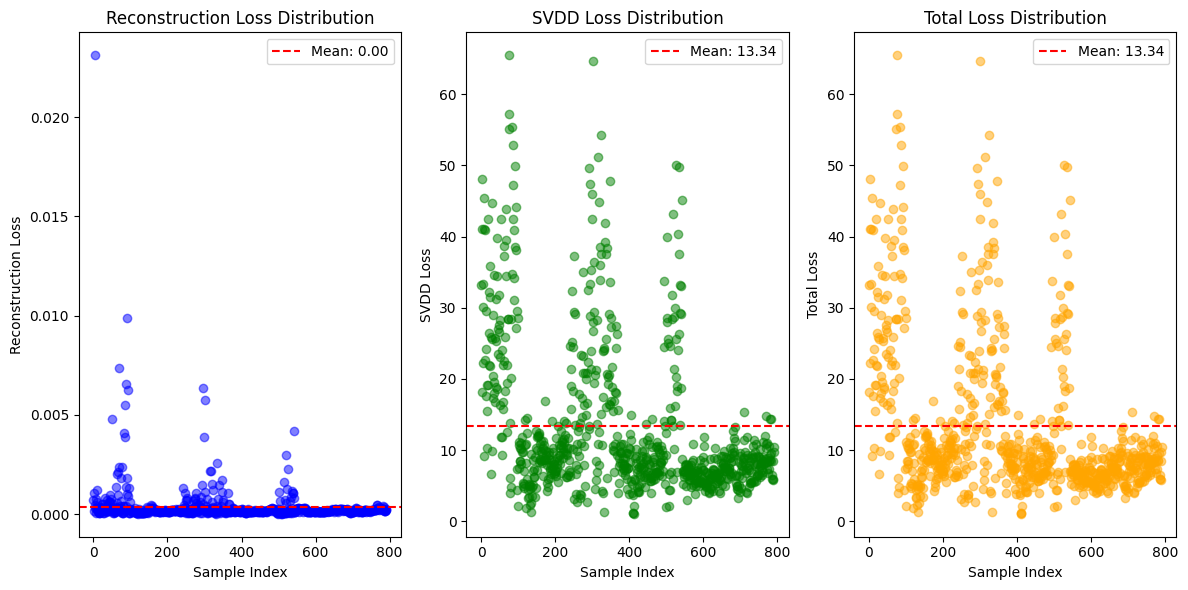

In [5]:
import matplotlib.pyplot as plt
reconstruction_losses_val = []
svdd_losses_val = []
total_losses_val = []
total_z_val = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio,_,_ = val_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        anomaly_score, reconstructed_audio, reconstructed_imu,z= model(audio, image)
        reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio) 
        svdd_loss = anomaly_score
        total_loss = svdd_loss + reconstruction_loss
        reconstruction_losses_val.append(reconstruction_loss.item())
        svdd_losses_val.append(svdd_loss.item())
        total_losses_val.append(total_loss.item())
        total_z_val.append(z.squeeze().detach().cpu().numpy())
        total_sample+=1

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses_val) / len(reconstruction_losses_val)
mean_svdd_loss = sum(svdd_losses_val) / len(svdd_losses_val)
mean_total_loss = sum(total_losses_val) / len(total_losses_val)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(total_sample), reconstruction_losses_val, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), 0.8)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(total_sample), svdd_losses_val, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses_val), 0.32)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(total_sample), total_losses_val, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
# plt.ylim(min(total_losses),2)
plt.legend()

plt.tight_layout()
plt.show()

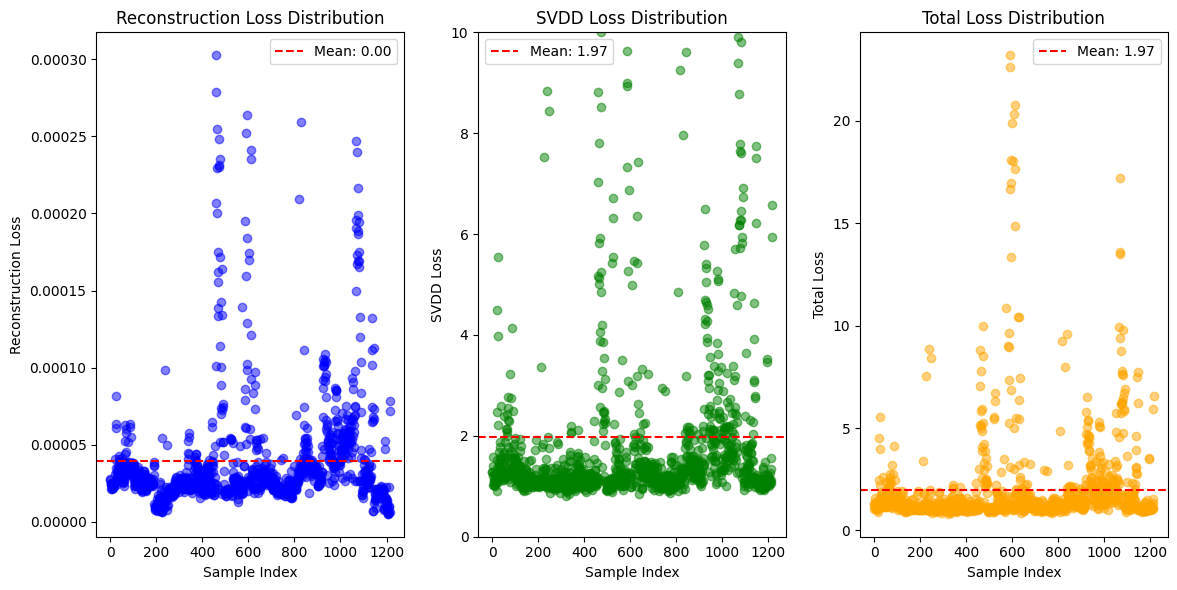

In [6]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_train = []
svdd_losses_train = []
total_losses_train = []
total_z_train = []
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, image, audio,_,_ = train_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # Forward pass through the model
        anomaly_score, reconstructed_audio, reconstructed_imu,z = model(audio, image)

        reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio) 
        svdd_loss = anomaly_score
        total_loss = svdd_loss + reconstruction_loss
        reconstruction_losses_train.append(reconstruction_loss.item())
        svdd_losses_train.append(svdd_loss.item())
        total_losses_train.append(total_loss.item())
        total_z_train.append(z.squeeze().detach().cpu().numpy())
        

mean_reconstruction_loss = sum(reconstruction_losses_train) / len(reconstruction_losses_train)
mean_svdd_loss = sum(svdd_losses_train) / len(svdd_losses_train)
mean_total_loss = sum(total_losses_train) / len(total_losses_train)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(train_data)), reconstruction_losses_train, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(train_data)), svdd_losses_train, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
plt.ylim(0, 10)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(train_data)), total_losses_train, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()

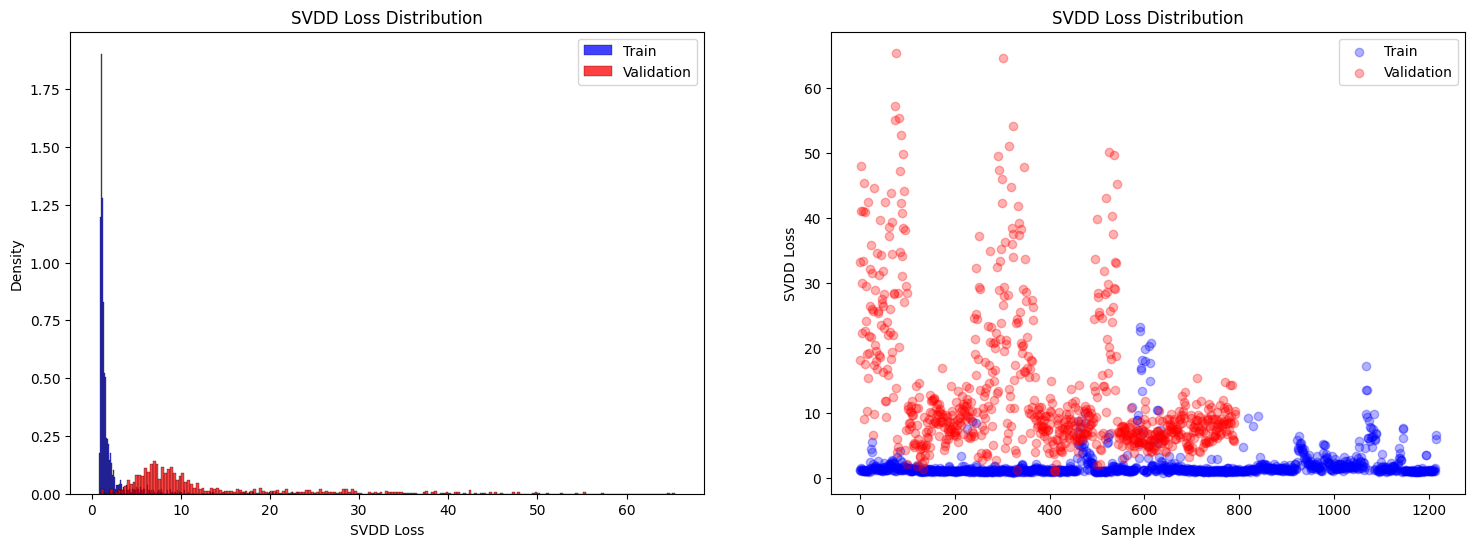

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
# plt.figure(figsize=(10, 5))
sns.histplot(svdd_losses_train, color='blue', label='Train', kde=False, bins=200, stat="density")
sns.histplot(svdd_losses_val, color='red', label='Validation', kde=False, bins=200, stat="density")
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(svdd_losses_train)), svdd_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(svdd_losses_val)), svdd_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
# plt.ylim(0,0.3)
plt.title('SVDD Loss Distribution')
plt.legend()

In [22]:
from deepod.metrics import ts_metrics
loss_all_audio = svdd_losses_train+svdd_losses_val
loss_all_audio = np.array(loss_all_audio)
loss_all_recons = reconstruction_losses_train+reconstruction_losses_val
loss_all_recons = np.array(loss_all_recons)

labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
loss_all = [ x +3340*y for x, y in zip(loss_all_audio, loss_all_recons)]

eval_metrics_all = ts_metrics(labels_all, (loss_all))

print(eval_metrics_all[:-2])

(0.9695879435805422, 0.9401535928549312, 0.9234399899538932, 0.8772727272727273, 0.9747474747474747)


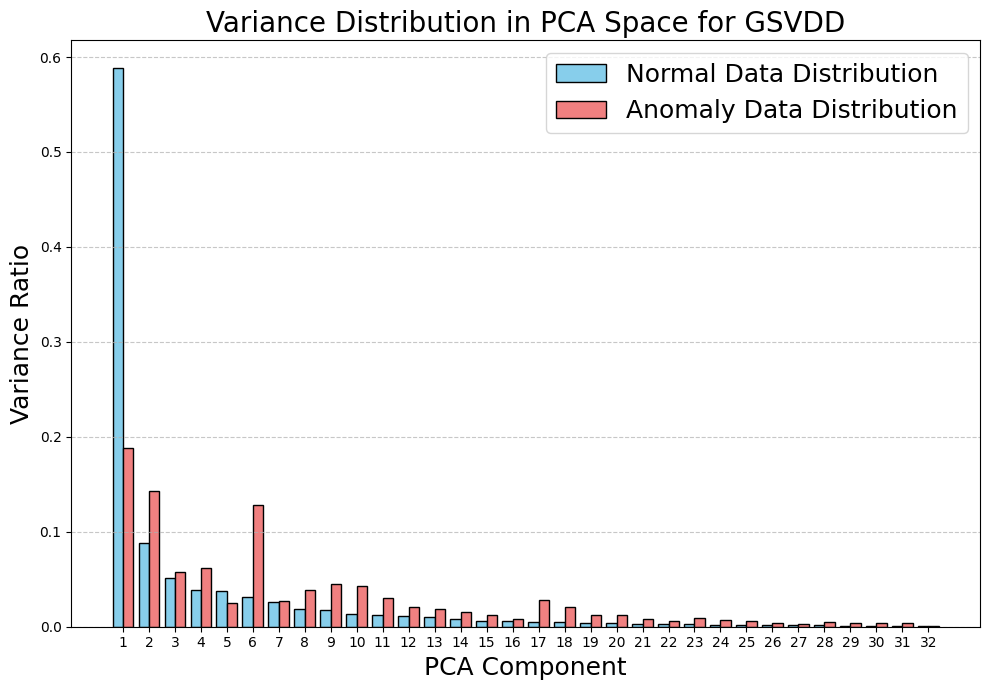

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming normal_features and anomaly_features are your input data
# Shapes: (n_normal, feature_dim) and (n_anomaly, feature_dim)
normal_features = total_z_train
anomaly_features = total_z_val

# Step 1: Fit PCA on normal features
pca = PCA(n_components=32)
pca.fit(normal_features)

# Step 2: Get the explained variance ratio for normal features
explained_variance_ratio = pca.explained_variance_ratio_

# Step 3: Transform both normal and anomaly features into the PCA space
normal_pca_projection = pca.transform(normal_features)
anomaly_pca_projection = pca.transform(anomaly_features)

# Step 4: Calculate variances for normal and anomaly projections in PCA space
normal_variances = np.var(normal_pca_projection, axis=0)
anomaly_variances = np.var(anomaly_pca_projection, axis=0)

# Step 5: Plot the explained variance and anomaly variances
plt.figure(figsize=(10, 7))

# Bar plot for normal feature explained variance
x = np.arange(1, len(explained_variance_ratio) + 1)  # Component indices
plt.bar(x - 0.2, explained_variance_ratio, width=0.4, color='skyblue', edgecolor='black', label='Normal Data Distribution')

# Bar plot for anomaly feature variances
plt.bar(x + 0.2, anomaly_variances / np.sum(anomaly_variances), width=0.4, color='lightcoral', edgecolor='black', label='Anomaly Data Distribution')

# Add labels and title
plt.title("Variance Distribution in PCA Space for GSVDD", fontsize=20)
plt.xlabel("PCA Component", fontsize=18)
plt.ylabel("Variance Ratio", fontsize=18)
plt.xticks(x)  # Ensure each component is labeled
plt.legend(fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

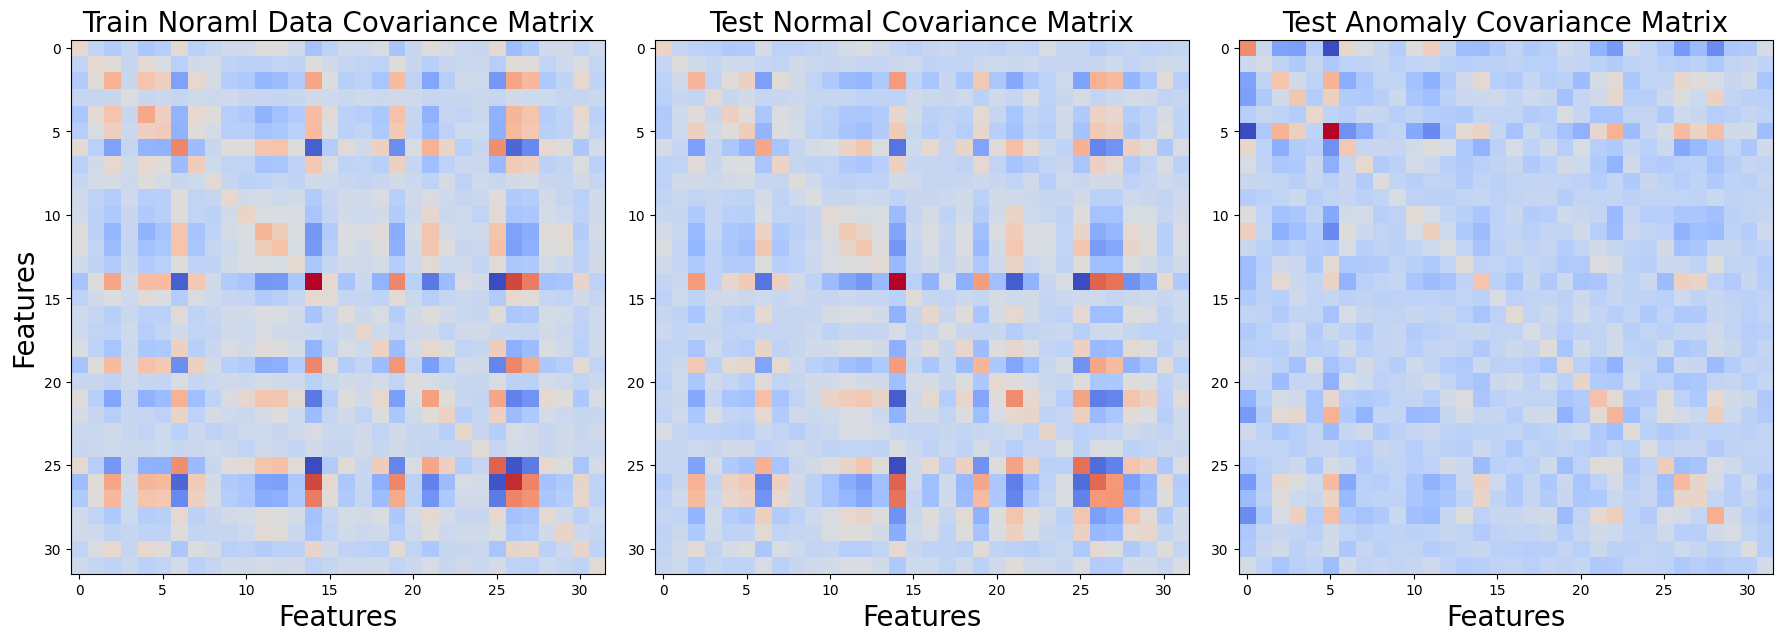

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean vectors and covariance matrices for train and validation sets
mean_vector_train = np.mean(total_z_train, axis=0)
covariance_matrix_train = np.cov(total_z_train, rowvar=False)

mean_vector_val = np.mean(total_z_val, axis=0)
covariance_matrix_val = np.cov(total_z_val, rowvar=False)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Train covariance matrix
axs[0].imshow(np.linalg.inv(sigma_inv_matrix), cmap='coolwarm')
axs[0].set_title("Train Noraml Data Covariance Matrix", fontsize=20)
axs[0].set_xlabel("Features", fontsize=20)
axs[0].set_ylabel("Features", fontsize=20)

# Validation covariance matrix
axs[1].imshow(covariance_matrix_train, cmap='coolwarm')
axs[1].set_title("Test Normal Covariance Matrix", fontsize=20)
axs[1].set_xlabel("Features", fontsize=20)

# Real (inverse covariance matrix)
axs[2].imshow(covariance_matrix_val, cmap='coolwarm')
axs[2].set_title("Test Anomaly Covariance Matrix", fontsize=20)
axs[2].set_xlabel("Features", fontsize=20)

# # Add colorbars for each plot
# for ax in axs:
#     cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
#     cbar.set_label("Value Scale")

# Adjust layout
plt.tight_layout()
plt.show()


In [101]:
from sklearn import metrics
precision, recall, thresholds= metrics.precision_recall_curve(labels_all, (loss_all_audio))
epsilon = 1e-10
f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(best_threshold)

4.652842044830322


In [102]:
normal_list = train_data.audio_list
indoor_group = []
outdoor_group = []

for idx, filepath in enumerate(normal_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['iseq2', 'iseq5'] or (sequence == 'seq16' and  file_number >= 104):
        indoor_group.append(idx)  # Add the index of the file
    else:
        outdoor_group.append(idx)  # Add the index of the file
print(len(indoor_group),len(outdoor_group))
indoor_losses = [svdd_losses_train[idx] for idx in indoor_group]
outdoor_losses = [svdd_losses_train[idx] for idx in outdoor_group]

642 574


In [103]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_indoor = [0] * len(indoor_losses)  # All indoor samples are normal
true_labels_outdoor = [0] * len(outdoor_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = indoor_losses + outdoor_losses
all_true_labels = true_labels_indoor + true_labels_outdoor

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_indoor = sum(predicted_labels[i] == true_labels_indoor[i] for i in range(len(indoor_losses))) / len(indoor_losses) if len(indoor_losses) > 0 else 0
accuracy_outdoor = sum(predicted_labels[len(indoor_losses) + i] == true_labels_outdoor[i] for i in range(len(outdoor_losses))) / len(outdoor_losses) if len(outdoor_losses) > 0 else 0

print("\nIndoor Group Accuracy:")
print(f"  Accuracy: {accuracy_indoor:.4f}")

print("\nOutdoor Group Accuracy:")
print(f"  Accuracy: {accuracy_outdoor:.4f}")


Overall Accuracy:
  Accuracy: 0.9137

Indoor Group Accuracy:
  Accuracy: 0.8894

Outdoor Group Accuracy:
  Accuracy: 0.9408


In [104]:
abnormal_list = val_data.audio_list
mach_group = []
coli_group = []

for idx, filepath in enumerate(abnormal_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    # file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['bl', 'br','fl','fr']:
        mach_group.append(idx)  # Add the index of the file
    else:
        coli_group.append(idx)  # Add the index of the file
        
mach_losses = [svdd_losses_val[idx] for idx in mach_group]
coli_losses = [svdd_losses_val[idx] for idx in coli_group]
print(len(mach_losses),len(coli_losses))

513 279


In [105]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_mach = [1] * len(mach_losses)  # All indoor samples are normal
true_labels_coli = [1] * len(coli_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = mach_losses + coli_losses
all_true_labels = true_labels_mach + true_labels_coli

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_mach = sum(predicted_labels[i] == true_labels_mach[i] for i in range(len(mach_losses))) / len(mach_losses) if len(mach_losses) > 0 else 0
accuracy_coli = sum(predicted_labels[len(mach_losses) + i] == true_labels_coli[i] for i in range(len(coli_losses))) / len(coli_losses) if len(outdoor_losses) > 0 else 0

print("\nmach Group Accuracy:")
print(f"  Accuracy: {accuracy_mach:.4f}")

print("\ncoli Group Accuracy:")
print(f"  Accuracy: {accuracy_coli:.4f}")


Overall Accuracy:
  Accuracy: 0.9634

mach Group Accuracy:
  Accuracy: 0.9669

coli Group Accuracy:
  Accuracy: 0.9570


t-SNE completed in 1.38 seconds.


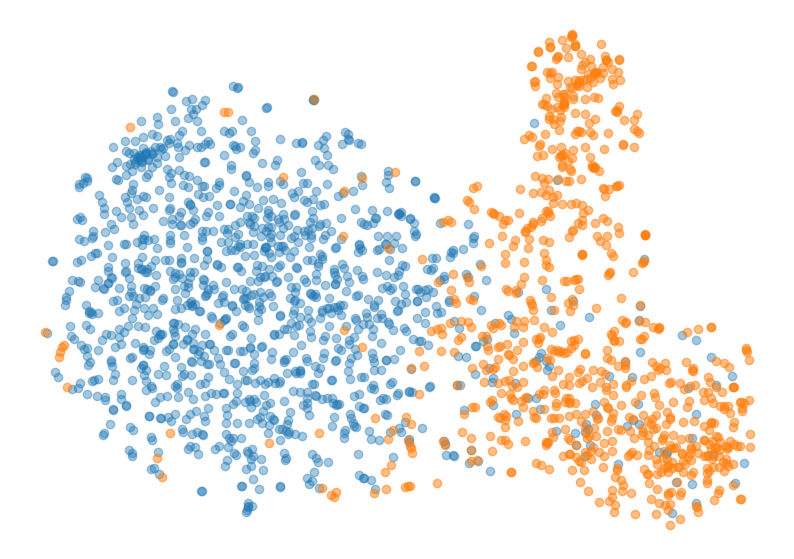

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

# Step 1: Convert your data to NumPy arrays
X_train = np.array(total_z_train)
X_test = np.array(total_z_val)

# Step 2: Combine train and test data for t-SNE
X_combined = np.vstack((X_train, X_test))

# Step 3: Start the timer for t-SNE
time_start = time.time()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0, n_iter=500)  # Adjust n_iter if necessary
X_tsne = tsne.fit_transform(X_combined)

# Calculate the time taken for t-SNE
time_end = time.time()
print(f"t-SNE completed in {time_end - time_start:.2f} seconds.")

# Step 4: Separate the t-SNE results back into train and test
X_train_tsne = X_tsne[:len(X_train)]
X_test_tsne = X_tsne[len(X_train):]

# Step 5: Plot the t-SNE results without axis and save with high resolution
plt.figure(figsize=(10, 7))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.4)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], alpha=0.5)

# Remove axis and legend (if you don't want it)
plt.axis('off')

# Save the figure with high resolution (300 DPI)
# plt.savefig('/home/iot/collision_detect/svdd/ploting/figures/tsne_plot_gsvdd2', dpi=500, bbox_inches='tight', pad_inches=0)

plt.show()


In [207]:
tab_colors = plt.get_cmap('tab10').colors


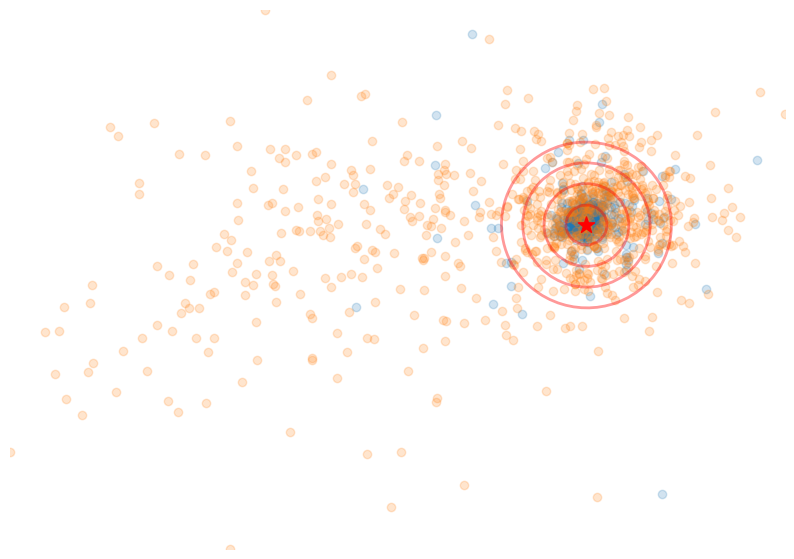

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
mu = model.mu.cpu().numpy()
sigma_inv = model.sigma_inv.cpu().numpy()
def plot_ellipsoid(mu, sigma_inv, X_train, X_test, mahalanobis_distances=[0.97, 2, 3,4], file_name='ellipsoid_plot.png'):
    """
    Plots the ellipsoid based on Mahalanobis distance, as well as X_train and X_test.
    
    Parameters:
    - mu: Mean vector.
    - sigma_inv: Inverse covariance matrix.
    - X_train: Training data.
    - X_test: Test data.
    - mahalanobis_distances: List of Mahalanobis distances to plot the ellipsoids for.
    - file_name: Name of the file to save the plot as a PNG.
    """
    
    # Step 1: Define a grid of points in the space of the first two features (for visualization)
    x_min, x_max = np.min(np.vstack((X_train, X_test))[:, 0]), np.max(np.vstack((X_train, X_test))[:, 0])
    y_min, y_max = np.min(np.vstack((X_train, X_test))[:, 1]), np.max(np.vstack((X_train, X_test))[:, 1])
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[x.ravel(), y.ravel()]

    # Step 2: Calculate Mahalanobis distance for each point in the grid
    mahalanobis_grid = []
    for point in grid_points:
        diff = point - mu[:2]
        mahalanobis_grid.append(np.sqrt(np.dot(np.dot(diff.T, sigma_inv[:2, :2]), diff)))

    mahalanobis_grid = np.array(mahalanobis_grid).reshape(x.shape)

    # Step 3: Plot the scatter plot of training and testing data
    plt.figure(figsize=(10, 7))

    # Default orange and blue colors for train and test
    plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2,color=tab_colors[0])
    plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.2,color=tab_colors[1])


    # Step 4: Plot the ellipsoid contours for specified Mahalanobis distances
    for d in mahalanobis_distances:
        plt.contour(x, y, mahalanobis_grid, levels=[d], colors='r', alpha=0.4, linewidths=2)

    # Step 5: Plot the mean (center) of the ellipsoid
    plt.scatter(mu[0], mu[1], color='r', marker='*', s=150)

    # Step 6: Remove axis, legend, and title
    plt.axis('off')

    # Step 7: Save the plot as a high-resolution PNG
    # plt.savefig(file_name, bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.close()

# Example usage

# Assuming mu, sigma_inv, X_train, and X_test are available as NumPy arrays
plot_ellipsoid(mu, sigma_inv, X_train, X_test, file_name='/home/iot/collision_detect/svdd/ploting/figures/ellipsoid_plot2.png')


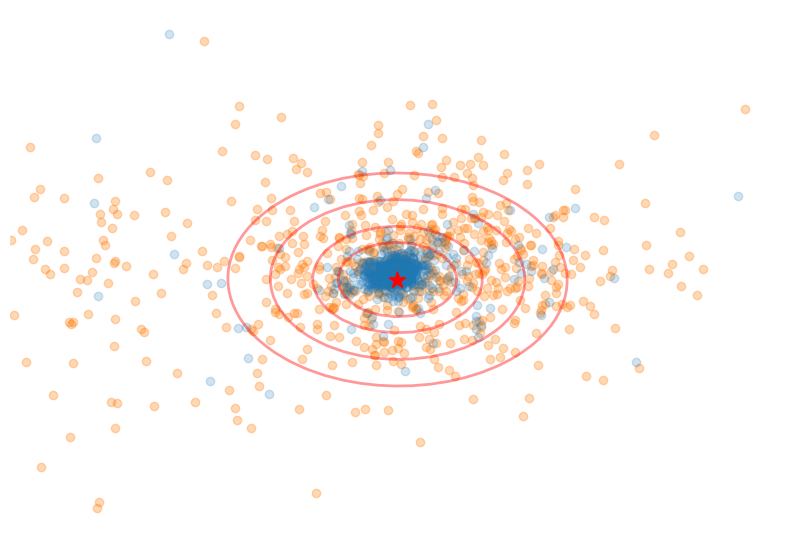

In [209]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def plot_ellipsoid(mu, sigma_inv, X_train, X_test, mahalanobis_distances=[1.4, 2, 3, 4], file_name='ellipsoid_plot.png'):
    """
    Plots the ellipsoid based on Mahalanobis distance, as well as X_train and X_test.
    
    Parameters:
    - mu: Mean vector.
    - sigma_inv: Inverse covariance matrix.
    - X_train: Training data.
    - X_test: Test data.
    - mahalanobis_distances: List of Mahalanobis distances to plot the ellipsoids for.
    - file_name: Name of the file to save the plot as a PNG.
    """
    
    # Step 1: Define a grid of points in the space of the first two features (for visualization)
    x_min, x_max = np.min(np.vstack((X_train, X_test))[:, 0]-0.05), np.max(np.vstack((X_train, X_test))[:, 0])
    y_min, y_max = np.min(np.vstack((X_train, X_test))[:, 1]), np.max(np.vstack((X_train, X_test))[:, 1])
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[x.ravel(), y.ravel()]

    # Step 2: Calculate Mahalanobis distance for each point in the grid
    mahalanobis_grid = []
    for point in grid_points:
        diff = point - mu[:2]
        mahalanobis_grid.append(np.sqrt(np.dot(np.dot(diff.T, sigma_inv[:2, :2]), diff)))

    mahalanobis_grid = np.array(mahalanobis_grid).reshape(x.shape)

    # Step 3: Plot the scatter plot of training and testing data
    plt.figure(figsize=(10, 7))

    # Default orange and blue colors for train and test
    plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.3, color=tab_colors[1])
    plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2, color=tab_colors[0])


    # Step 4: Plot the ellipsoid contours for specified Mahalanobis distances
    for d in mahalanobis_distances:
        plt.contour(x, y, mahalanobis_grid, levels=[d], colors='r', alpha=0.4, linewidths=2)

    # Step 5: Plot the mean (center) of the ellipsoid
    plt.scatter(mu[0], mu[1], color='r', marker='*', s=150)

    # Step 6: Automatically set axis limits based on the max Mahalanobis distance
    max_distance = np.max(mahalanobis_distances) /35
    plt.xlim(mu[0] - max_distance, mu[0] + max_distance)
    plt.ylim(mu[1] - max_distance, mu[1] + max_distance)

    # Step 7: Remove axis, legend, and title
    plt.axis('off')

    # Step 8: Save the plot as a high-resolution PNG
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.close()

# Example usage
# Assuming mu, sigma_inv, X_train, and X_test are available as NumPy arrays
plot_ellipsoid(mu, sigma_inv, X_train, X_test, file_name='/home/iot/collision_detect/svdd/ploting/figures/ellipsoid_plot3.png')
